In [224]:
import os
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal

import pandas as pd

from IPython.display import Image

from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler

import warnings

In [225]:
%config InlineBackend.figure_format='retina'

In [226]:
force_cpu = True
if not force_cpu:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Using device", device)

Using device cpu


In [227]:
# try:
#     from google.colab import drive
#     drive.mount('/content/drive')
#     root = '/content/drive/MyDrive/Colab Notebooks'
# except:
root = '.'

fig_folder = f"{root}/figures"
backup_folder = f"{root}/backup"

os.listdir(root)
for f in fig_folder, backup_folder:
    os.makedirs(f, exist_ok=True)

print("Backup folder:", backup_folder)
print("Figures folder:", fig_folder)

Backup folder: ./backup
Figures folder: ./figures


# CartPole env

In [228]:
import gymnasium as gym
env = gym.make('CartPole-v1')

In [229]:
print((env.action_space.n))

2


In [230]:
def eval_trajectory(env, trajectory):
    
    observation, info = env.reset(seed=0)
    t = 0
    terminated, truncated = False, False
    while not terminated and not truncated:
        try:
            action = trajectory[t]
            # action = env.action_space.sample()  # agent policy that uses the observation and info
            observation, reward, terminated, truncated, info = env.step(action)
            t += 1
        except IndexError:
            break
    return t


def eval_policy(env, policy, p=None, kl_div_factor=0.001, n_sample=10):
    
    q = dist.Binomial(probs=policy)
    trajectories = q.sample((n_sample, ))
    
    loss, p_sum = 0, 0

    for traj in trajectories:

        reward = eval_trajectory(trajectory=traj.long().cpu().numpy(), env=env)

        p_traj = q.log_prob(traj).sum().exp()
        loss -= p_traj * reward
        p_sum += p_traj

    loss /= p_sum
    
    if p is not None:
        kl_div = dist.kl_divergence(q, p).sum()
        loss += kl_div_factor * kl_div
    
    return loss/len(policy)

# Creating a dataset

In [231]:
class TrajectoryDataset(Dataset): 
    def __init__(self, x, y):
        self.x = x
        self.y = y
        super().__init__()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [232]:
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(1234)

n_sample = 2000
n_steps = 50

print("creating samples")
p = dist.Binomial(probs=torch.ones(n_steps)*0.5)
x = p.sample((n_sample, ))
print(x.shape)


y = torch.zeros(n_sample)
for i, trajectory in enumerate(x):
    y[i] = eval_trajectory(env=env, trajectory=trajectory.int().numpy())
y /= n_steps

# Exclude best ones
not_too_good = y <= 0.8
y = y[not_too_good]
x = x[not_too_good]

train_dataset = TrajectoryDataset(x=x.to(device), y=y.to(device))

creating samples
torch.Size([2000, 50])


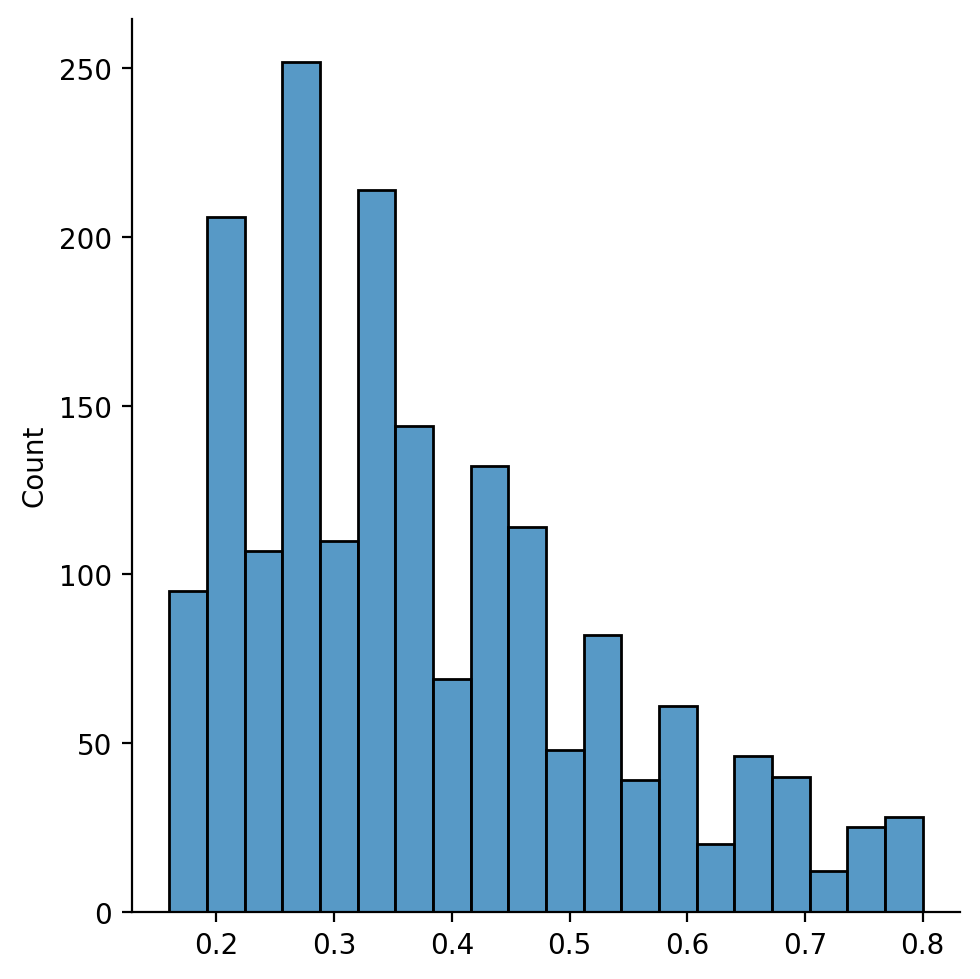

In [233]:
sns.displot(train_dataset.y.cpu().numpy());

# VAE

## Defining the VAE model

In [234]:
class VAE(nn.Module):
    def __init__(self, n_steps, size_z, out_encoder=20):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Linear(n_steps, 500),
            nn.LeakyReLU(),
            nn.Linear(500, 500),
            nn.LeakyReLU(),
            nn.Linear(500, 500),
            nn.LeakyReLU(),
            nn.Linear(500, out_encoder),
        )
        self.mu = nn.Linear(out_encoder, size_z)
        self.logvar = nn.Linear(out_encoder, size_z)
        
        self.dec = nn.Sequential(
            nn.Linear(size_z, 500),
            nn.LeakyReLU(),
            nn.Linear(500, 500),
            nn.LeakyReLU(),
            nn.Linear(500, 500),
            nn.LeakyReLU(),
            nn.Linear(500, n_steps)
        )

    def encode(self, x):
        x = self.enc(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = self.dec(z)
        x = torch.sigmoid(z)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class Regression(nn.Module):
    def __init__(self, size_z):
        super().__init__()
        self.pred = nn.Sequential(
            nn.Linear(size_z, 500),
            nn.LeakyReLU(),
            nn.Linear(500, 500),
            nn.LeakyReLU(),
            nn.Linear(500, 500),
            nn.LeakyReLU(),
            nn.Linear(500, 1)
        )

    def forward(self, x):
        x = self.pred(x)
        x = torch.sigmoid(x.squeeze())     
        return x

## Training VAE

In [235]:
seed = 123
size_z = 2
lr = 0.001
batch_size=len(train_dataset.y)
n_epoch = 2000
weight_reg_loss = 10e3

torch.manual_seed(seed)

vae = VAE(n_steps=n_steps, size_z=size_z).to(device)
reg = Regression(size_z).to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

optimizer_vae = optim.Adam(list(vae.parameters()) + list(reg.parameters()), lr=lr)

with tqdm(total=n_epoch, leave=True) as pbar:
    
    for epoch in range(n_epoch):
        
        vae_loss, reg_loss = 0, 0
                    
        for batch_idx, (x, y) in enumerate(train_loader):

            optimizer_vae.zero_grad()

            recon_x, mu, logvar = vae(x)
            bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
            # https://arxiv.org/abs/1312.6114
            # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
            kl = - 0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
            l_vae = bce + 0.01 * kl

            pred = reg(mu)
            l_reg = weight_reg_loss*nn.MSELoss(reduction="sum")(target=y, input=pred)

            loss = l_vae + l_reg
            
            loss.backward()
            optimizer_vae.step()

            vae_loss += l_vae.item()
            reg_loss += l_reg.item()
        # if epoch > 0 and epoch % 50 == 0:
        pbar.update()
        pbar.set_postfix({
            "loss VAE": f"{vae_loss/len(y):.4f}",
            "loss regression": f"{reg_loss/len(y):.4f}"
        })

  0%|          | 0/2000 [00:00<?, ?it/s]

## Assessing reconstruction error

In [236]:
x = train_dataset.x
with torch.no_grad():
    recon_x, mu, logvar = vae(x)

#for i in range(len(x)):
#    print(np.abs(x[i].numpy() - recon_x[i].numpy()))
delta = np.abs(x.numpy() - recon_x.numpy())
print(f"Avg error: {np.mean(delta):.3f} +/- {np.std(delta):.3f}")

Avg error: 0.353 +/- 0.219


## Visualize structuration of the latent space

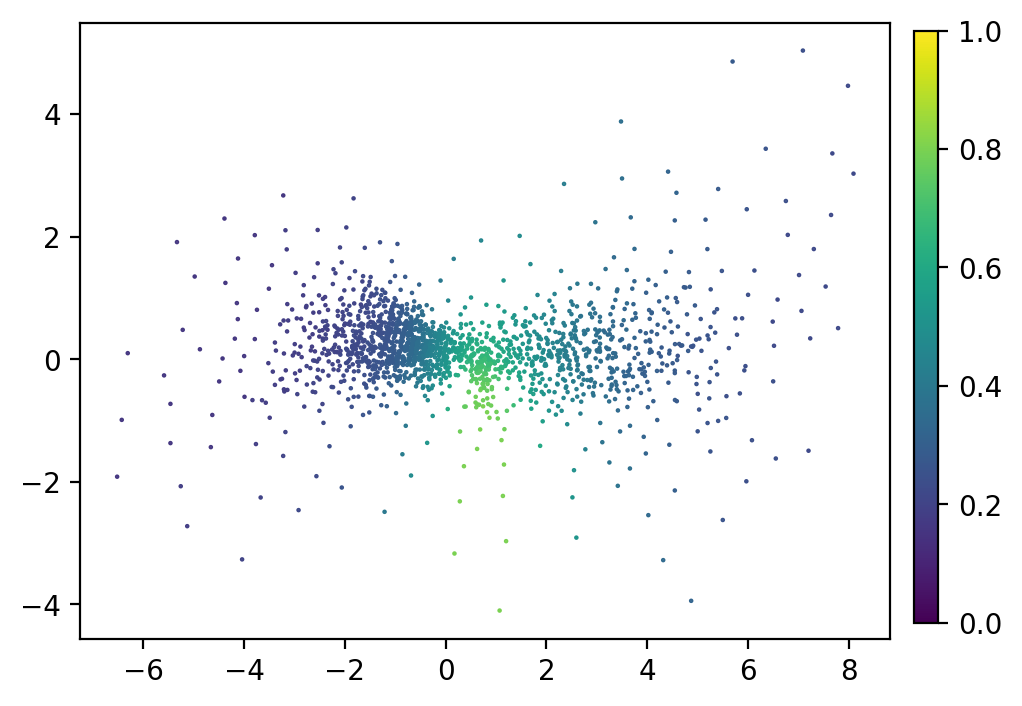

In [237]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 4))

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    vmin=0.0, vmax=1.0,
    marker='o', s=0.4)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

(-6.520216, 8.092462)
(-4.104715, 5.036057)


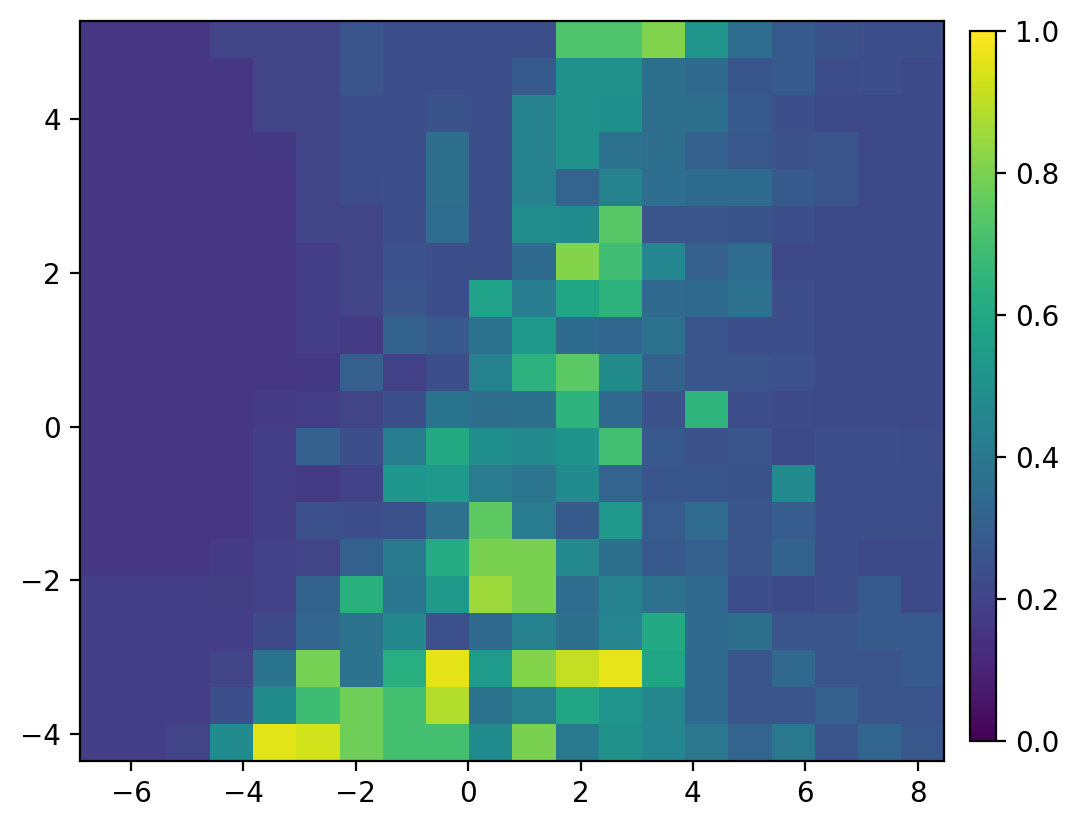

In [238]:
x_lim = min(z[:, 0]), max(z[:, 0]) 
y_lim = min(z[:, 1]), max(z[:, 1]) 

vae.eval()
rx, ry = np.linspace(*x_lim, 20), np.linspace(*y_lim, 20)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)

    y = torch.tensor([
        - eval_policy(
            env=env,
            policy=pol) for pol in x])  

    x = x.cpu().numpy()
    y = y.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

# im = plt.contourf(gx, gy, gz, cmap='viridis')
fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz, vmin=0.0, vmax=1.0)
fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));
print(x_lim)
print(y_lim)

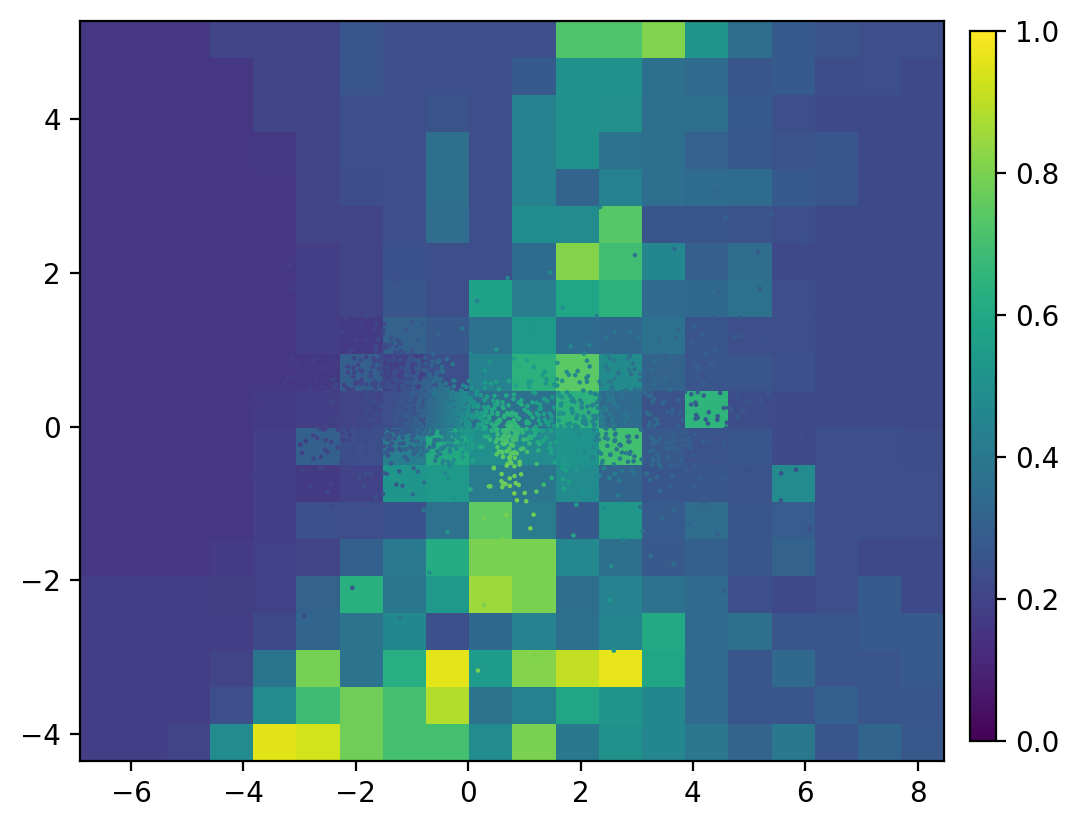

In [239]:
fig, ax = plt.subplots()
ax.pcolormesh(gx, gy, gz, vmin=0.0, vmax=1.0);

vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    vmin=0.0, vmax=1.0,
    marker='o', s=0.4)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

## Same thing but using the regressor from the latent

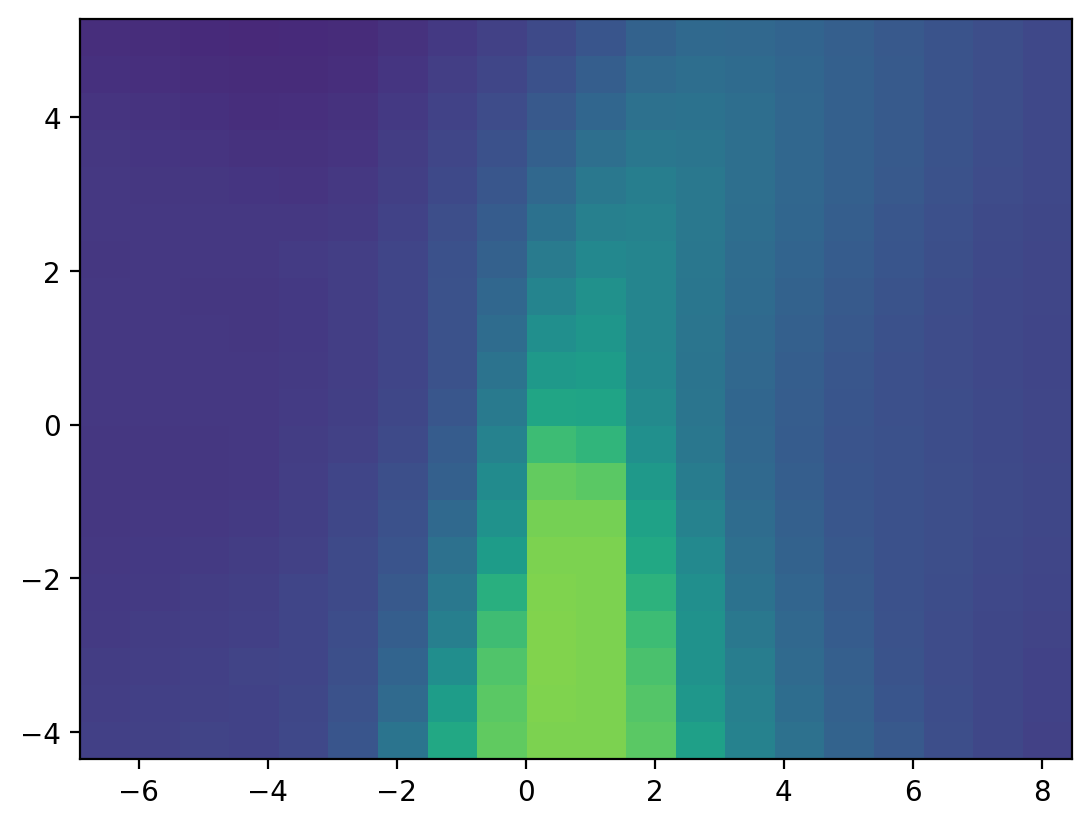

In [240]:
vae.eval()
rx, ry = np.linspace(*x_lim, 20), np.linspace(*y_lim, 20)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()

    y = reg(z)
    
    # x = x.cpu().numpy()
    y = y.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
ax.pcolormesh(gx, gy, gz, vmin=0.0, vmax=1.0);

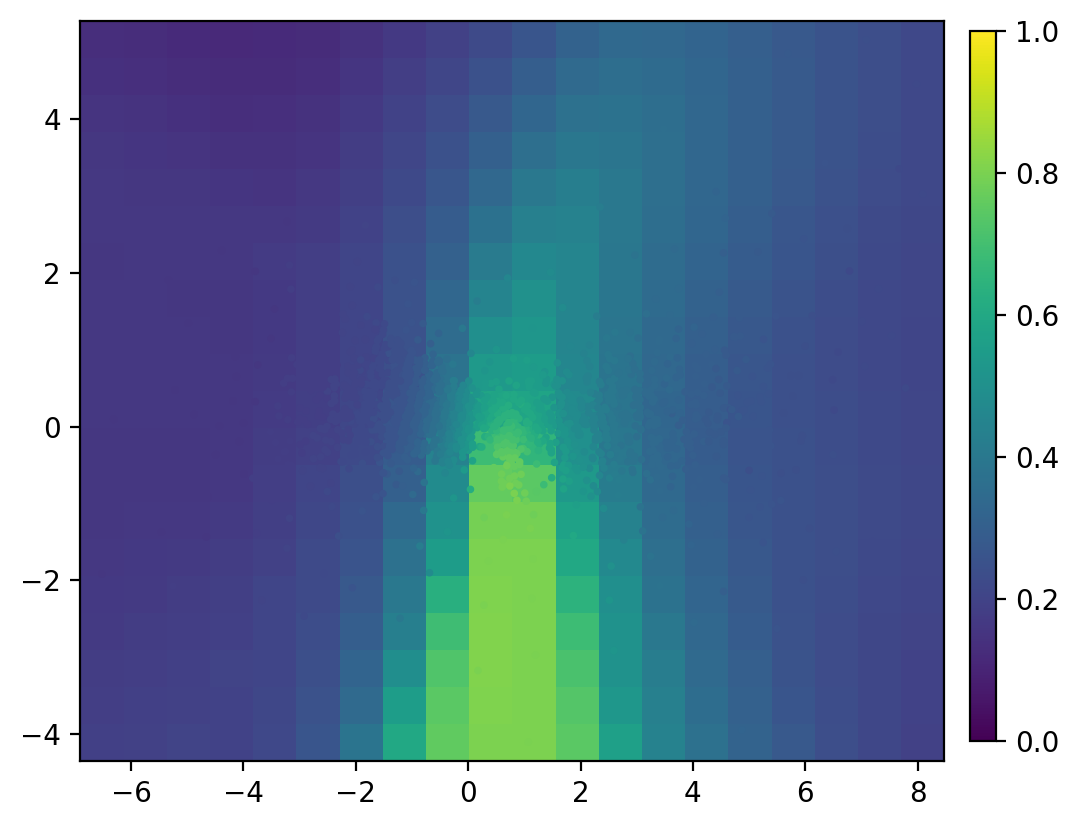

In [241]:
fig, ax = plt.subplots()
ax.pcolormesh(gx, gy, gz, vmin=0.0, vmax=1.0)

vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    vmin=0.0, vmax=1.0,
    marker='o', s=3.0)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

## Training from the latent but with NN

In [244]:
class DecisionMaker(nn.Module):
    def __init__(self, init_value):
        super().__init__()
        self.param = nn.Parameter(init_value)


dm_init_value, _ = vae.encode(train_dataset.x[torch.argmax(train_dataset.y)])

dm = DecisionMaker(init_value=dm_init_value)
dm.to(device)
dm.train()

hist_y = []

epochs= 200

optimizer = optim.Adam(dm.parameters(), lr=0.01)

with tqdm(total=epochs) as pbar:
    
    for epoch in range(epochs):
      
        optimizer.zero_grad()
        
        z = dm.param
        x = vae.decode(z)
        loss = eval_policy(env=env, policy=x, p=None).to(device)
        y = - loss
        
        loss.backward()
        optimizer.step()

        hist_y.append(y.detach().item())
        best_value = np.max(hist_y) 
        
        pbar.update()
        pbar.set_postfix(loss=f"{loss.item():.4f}", best=f"{best_value:.4f}")

  0%|          | 0/200 [00:00<?, ?it/s]

# Using GP after VAE trained

In [250]:
# Remove warnings
warnings.filterwarnings("ignore")

torch.manual_seed(123)

dtype=torch.float

acq_opt__batch_size = 5
acq_opt__num_restarts = 10
acq_opt__raw_samples = 256

qmc_sampler__sample_shape = 2048
qmc_sampler__seed = 123

n_batch = 20

n_sample_start = 20

best_observed = []
cand_observed = []
val_observed = []

# Create a small dataset from the dataset the VAE has been trained with
best = torch.topk(train_dataset.y, k=n_sample_start).indices
train_x = train_dataset.x[best]
train_y = train_dataset.y[best]
with torch.no_grad():
    vae.eval()
    train_z, _ = vae.encode(train_dataset.x[best])

state_dict = None
# run N_BATCH rounds of BayesOpt after the initial random batch
with tqdm(total=n_batch) as pbar:
    for iteration in range(n_batch):

        # fit the GP model
        # normalize(train_h, bounds=bounds), 
        # standardize(train_obj) 
        model = SingleTaskGP(train_X=train_z, train_Y=train_y.unsqueeze(dim=1))
        # if state_dict is not None:
        #     model.load_state_dict(state_dict)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        mll.to(device)
        fit_gpytorch_mll(mll)

        # define the qNEI acquisition module using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(
            sample_shape=qmc_sampler__sample_shape,
            seed=qmc_sampler__seed
        )
        qEI = qExpectedImprovement(
            model=model, 
            sampler=qmc_sampler, 
            best_f=train_y.max())

        # optimize and get new observation
        # optimize
        bounds = torch.zeros((2, size_z))
        bounds[0, :] = - 4
        bounds[1, :] = 4
        candidates, _ = optimize_acqf(
            acq_function=qEI,
            bounds=bounds,
            q=acq_opt__batch_size,
            num_restarts=acq_opt__num_restarts,
            raw_samples=acq_opt__raw_samples,
        )

        # observe new values 
        with torch.no_grad():
            new_z = candidates.detach()
            new_x = vae.decode(new_z)
            new_y = torch.tensor([
                - eval_policy(
                    env=env,
                    policy=pol) for pol in new_x])  

        # update training points
        train_z = torch.cat((train_z, new_z))
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))

        # update progress
        best_value = train_y.max().item()
        best_observed.append(best_value)
        cand_observed.append([cand.numpy().tolist() for cand in candidates])
        val_observed.append([val.item() for val in new_y])

        # state_dict = model.state_dict()
        
        pbar.update()
        pbar.set_postfix({"best": f"{best_value:.2f}"})

  0%|          | 0/20 [00:00<?, ?it/s]

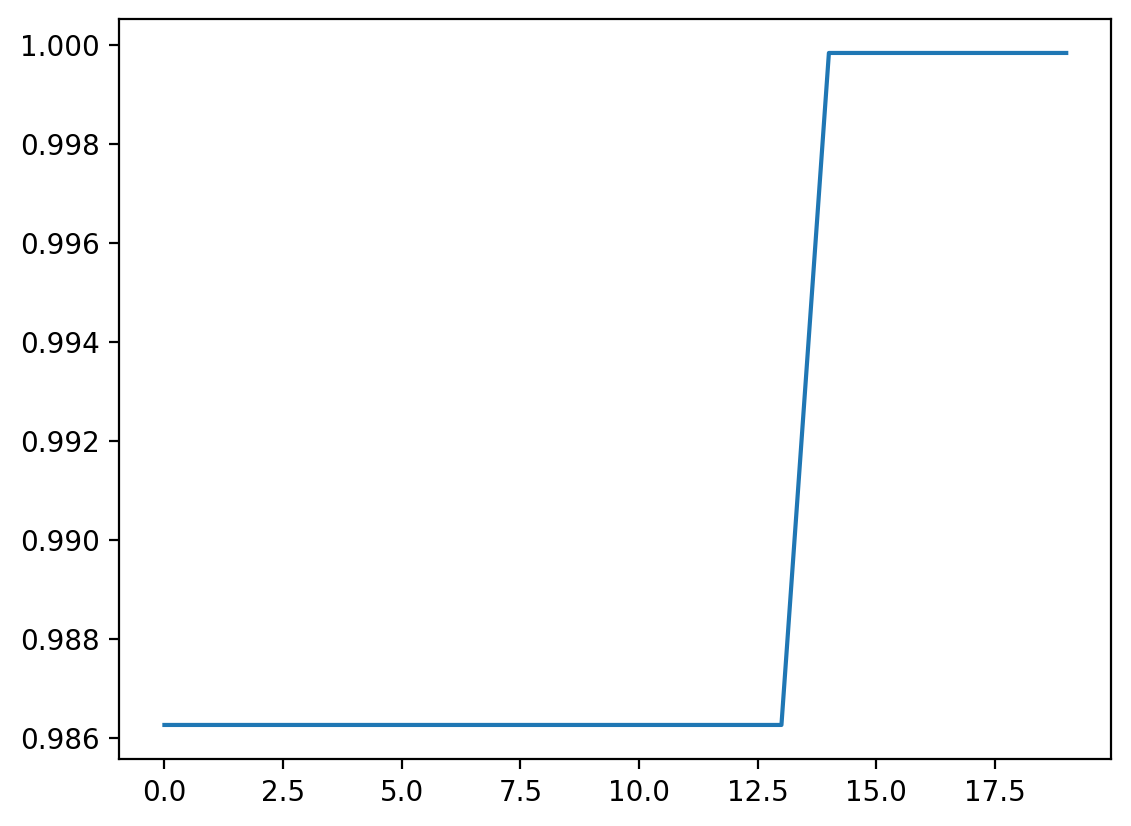

In [251]:
fig, ax = plt.subplots()
ax.plot(best_observed);

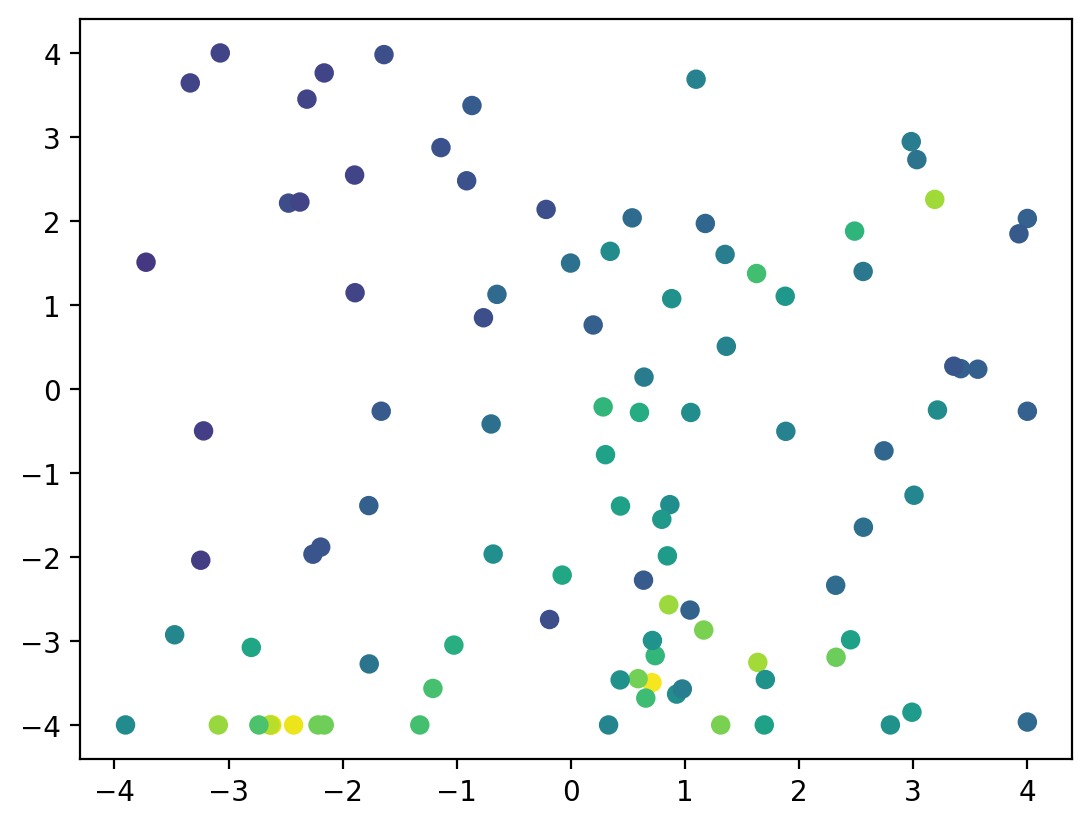

In [253]:
cand_observed = np.array(cand_observed)
val_observed = np.array(val_observed)
plt.scatter(x=cand_observed[:, :, 0], y=cand_observed[:, :, 1], c=val_observed,  cmap="viridis", vmin=0, vmax=1);

In [203]:
val_observed.max()

0.9462462067604065

## Train separately the decoder

In [221]:
for name, param in vae.named_parameters():
    if name.startswith("enc") or name.startswith("mu") or name.startswith("logvar"):
        param.requires_grad = False

n_sample = 500
print("creating samples")
p = dist.Binomial(probs=torch.ones(n_steps)*0.5)
x = p.sample((n_sample, ))

train_dataset_encoder = TrainDataset(
    train_x=x.to(device), 
    train_y=torch.zeros(n_sample).to(device))

print(train_dataset_encoder.train_x.shape)

lr = 0.001
n_epoch = 1000
batch_size = 200

hist_loss = []

train_loader = DataLoader(dataset=train_dataset_encoder, batch_size=batch_size)

optimizer = optim.Adam(list(vae.parameters()) + list(reg.parameters()), lr=lr)

with tqdm(total=n_epoch, leave=True) as pbar:
    
    for epoch in range(n_epoch):
        
        epoch_loss = 0
                    
        for batch_idx, (x, _) in enumerate(train_loader):

            optimizer_vae.zero_grad()

            recon_x, mu, logvar = vae(x)
            bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
            # https://arxiv.org/abs/1312.6114
            # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
            kl = - 0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
            loss = bce + kl
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss/len(x)
        hist_loss.append(avg_train_loss)
        
        pbar.update()
        pbar.set_postfix(loss=f"{avg_train_loss:.4f}")

creating samples
torch.Size([500, 50])


  0%|          | 0/1000 [00:00<?, ?it/s]